In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style = 'darkgrid')

from utils import scatter_plot
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Import Dataset

In [2]:
train = pd.read_csv('./data/SynDepth_train_set.csv', converters={'site_no': str}, low_memory=False)
test = pd.read_csv('./data/SynDepth_test_set.csv', converters={'site_no': str}, low_memory=False)

In [3]:
X_train = train.drop(columns=['site_no', 'mean_depth_va'])
X_test = test.drop(columns=['site_no', 'mean_depth_va'])

y_train = train[['mean_depth_va']]
y_test = test[['mean_depth_va']]

In [4]:
# log_train = np.log10(train.drop(columns=['site_no']).to_numpy())
# log_test = np.log10(test.drop(columns=['site_no']).to_numpy())

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train).astype('float32')

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1)).astype('float32').ravel()

X_test = X_scaler.transform(X_test).astype('float32')

In [5]:
## Model
mlp = MLPRegressor(max_iter=100)
param_grid = {
            'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'activation': ['logistic', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
            }

mlp_grid = GridSearchCV(mlp, param_grid, cv=8, n_jobs=30, verbose=3)
mlp_grid.fit(X_train, y_train)

Fitting 8 folds for each of 48 candidates, totalling 384 fits


GridSearchCV(cv=8, estimator=MLPRegressor(max_iter=100), n_jobs=30,
             param_grid={'activation': ['logistic', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             verbose=3)

In [6]:
print(mlp_grid.best_params_)
print(mlp_grid.best_score_)

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.9861471822915899


In [8]:
import pickle

with open('./data/ml_weights/mlp_best_model', "wb") as fp:
    pickle.dump(mlp_grid.best_estimator_, fp)

In [9]:
import pickle

with open('./data/ml_weights/mlp_best_model', "rb") as fp:
    mlp_grid = pickle.load(fp)

NSE: 0.9810, R2: 0.9813, PBias: -1.2473, MSE: 0.8491


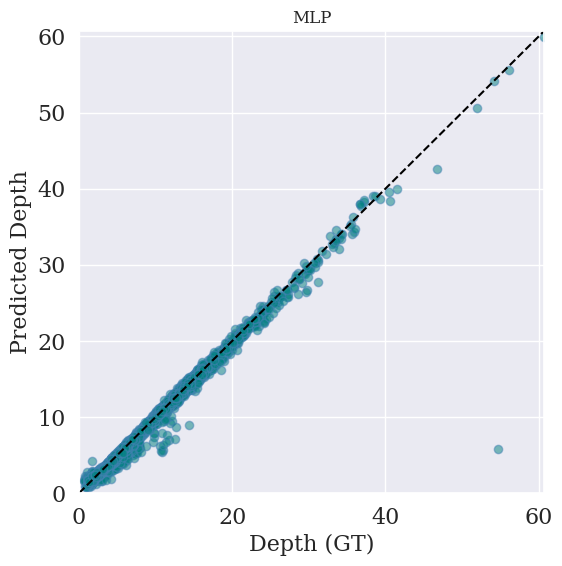

In [9]:
y_pred = mlp_grid.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
scatter_plot(y_test, y_pred, model_name='MLP')